This notebook solves a household problem with stochastic income fluctuation.
Model
--
The household chooses its consumption and savings while being constraint by its budget set. Savings pay a constant interest rate.

The sequence problem:
$$\underset{ \left(c_t, a_{t+1}\right)_{t=0}^\infty } {max} \sum_{t=0}^\infty \beta^t \, u( c_t )$$
s.t.
$$a_{t+1} = (1+r) a_t + y(s_t) - c_t \quad \forall t$$
$$a_t \geq \underline{a}\quad\forall t$$
$$a_0 \, \text{given}$$

can be written recursively as:

$$V(a, s) = \underset{ a' \geq \underline{a} } {max} \, u\big( (1+r) a + y(s) - a'  \big) + \beta \, \mathbb{E} \Big[ V \big(a', s' \big) \, \big| \,\theta \Big]$$
The solution of this Bellman equation is a policy function $a'(a, s)$ for consumption.

In [1]:
using Parameters
using BasisMatrices
using LaTeXStrings
using Plots; pyplot();
using QuantEcon

In [209]:
@with_kw immutable HHwIncomeFluct
    β::Float64                           # discount factor
    γ::Float64                           # RRA
    Π::Array{Float64,2}                  # transition probabilities
    Y::Vector{Float64}                   # income grid
    r::Float64                           # interest rate
end

household = HHwIncomeFluct(β = 0.96, γ = 2, Π = [0.95 0.05 0.0; 0.10 0.70 0.20; 0.0 0.25 0.75], 
    Y = [0.25, 0.75, 1.0], r = 0.03);

u_crra(c, γ) = c.^(1-γ) ./ (1-γ)
u_crra_prime(c, γ) = c.^-γ
u_crra_prime_inv(u, γ) = u.^(-1/γ)

u_crra_prime_inv (generic function with 1 method)

In [210]:
@unpack β, γ, Π, Y, r = household

basis = Basis(ChebParams(50, 5, 12), LinParams(Y, 0))
#basis = Basis(SplineParams(linspace(0.1,20,10), 0, 3), LinParams(Y, 0))

Ψ = BasisMatrix(basis, Expanded()).vals[1]
S, (A, Y) = nodes(basis);

In [75]:
V0 = vcat(u_crra((1+r)*A + Y[1], γ), u_crra((1+r)*A + Y[2], γ), u_crra((1+r)*A + Y[3], γ))
c0 = Ψ \ V0;

Numerical Method: Envelope Condition
--

In [5]:
c = copy(c0)
V = copy(V0)

V_old = zeros(V0)
uprime = zeros(V0)
stop = false
iteration = 0

while !stop
    
    V_old = copy(V)
    uprime = BasisMatrix(basis, Expanded(), S, [1 0]).vals[1] * c ./ (1+r)
    
    cons = u_crra_prime_inv(uprime, γ) 
    
    aprime = S[:,2] + (1+r) * S[:,1] - cons
    
    binding = aprime .< A[1]
    
    cons = ifelse.(binding, (1+r)*S[:,1] + S[:,2] - A[1], cons)
    aprime = ifelse.(binding, A[1], aprime)
    
    V = (u_crra(cons, γ) + β * sum(kron(Π, fill(1,size(basis, 1))) .* 
            hcat([(BasisMatrix(basis, Expanded(), hcat(aprime, fill(y,length(aprime)))).vals[1] * c) for y in Y]...),2))[:,1]
    
    c = Ψ \ V;
    

    iteration += 1
    if (iteration % 1 == 0) 
        ##
    end

    
    if (maximum(abs.(V-V_old)) < 1e-10 || iteration == 2)
        stop = true
    end
end

After two iterations the value function and its approximation look fine:


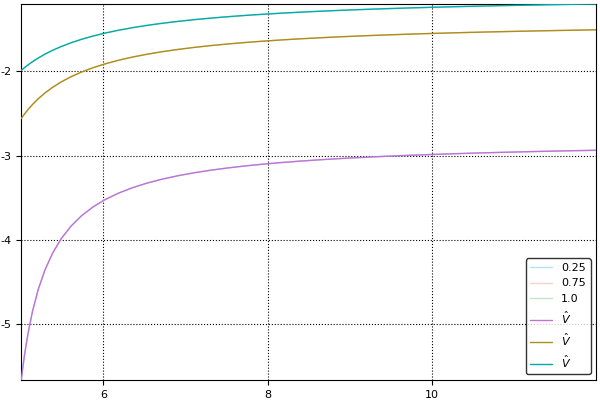

In [6]:
plot(A, reshape(V, size(basis, 1), size(basis, 2)), label = Y', alpha = 0.3)
plot!(A, reshape(BasisMatrix(basis, Expanded(), S, [0 0]).vals[1] * c, size(basis, 1), size(basis, 2)), label = L"\hat{V}")

But the derivative yields an instability in the calculation of consumption:


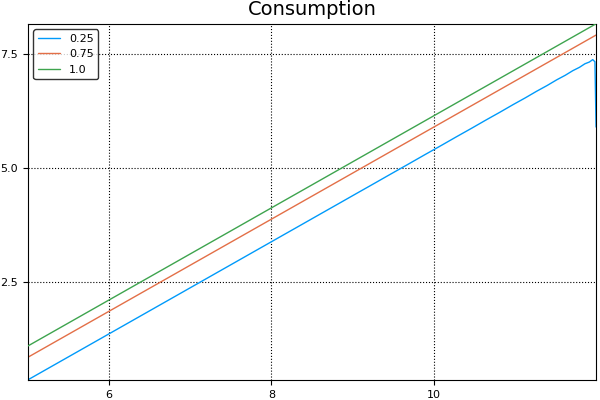

In [7]:
plot(A, reshape(u_crra_prime_inv(BasisMatrix(basis, Expanded(), S, [1 0]).vals[1] * c, γ), 
        size(basis, 1), size(basis, 2)), title = "Consumption", label = Y')

This leads to an error in iteration three.

Numerical Method: Collocation
--
unfinished!

In [8]:
using Parameters
using BasisMatrices
using LaTeXStrings
using Plots; pyplot();
using QuantEcon

In [9]:
@with_kw mutable struct HHwIncomeFluct
    β::Float64                           # discount factor
    γ::Float64                           # RRA

    # income
    Y_chain::MarkovChain{Float64, Matrix{Float64}, Vector{Float64}} # Markov chain of income
    
    # assets
    r::Float64                           # interest rate
    A::Vector{Float64}
    
    basis::Basis                         # main Basis type
    bs::BasisMatrix                      # main basis matrix (Direct)
    Φ::SparseMatrixCSC                   # main basis matric (Expanded)
    Emat::SparseMatrixCSC                # transition matrix times basis matrix
    Φy::SparseMatrixCSC                  # income part of the basis matrix
end

household = HHwIncomeFluct(β = 0.95, γ = 2, Π = [0.95 0.05 0.0; 0.10 0.70 0.20; 0.0 0.25 0.75], 
    Y = [0.25, 0.75, 1.0], r = 0.02);

u_crra(c, γ) = c.^(1-γ) ./ (1-γ)
u_crra_prime(c, γ) = c.^-γ
u_crra_prime_inv(u, γ) = u.^(-1/γ)

LoadError: [91minvalid redefinition of constant HHwIncomeFluct[39m

In [10]:
Emat = kron(Π, speye(length(A)))*Ψ;

In [11]:
@unpack β, γ, Π, Y, r = household

basis = Basis(SplineParams(linspace(0.1,20,10), 0, 3), LinParams(Y, 0))

bs = BasisMatrix(basis, Direct())
Φ = convert(bs, Expanded())
S, (A, Y) = nodes(basis)
Emat = kron(Π, speye(Na))*Φ
Φy = bs.vals[2] 

c = copy(c0)
V = copy(V0)

cE = copy(c0)
VE = copy(V0)

V_old = zeros(V0)
stop = false
iteration = 0

function evaluate(aprime, h::HHwIncomeFluct) 
    
end

while !stop
    
    
    
    lower_bound = zeros(size(S, 1), )
    upper_bound = (1 + r).*S[:, 1] + S[:, 2]
    f(ap::Vector{Float64}) = value(h, s, ap; other_pols=false)
    ap, v1 = golden_method(f, lower_bound, upper_bound)
    v1, Φapy = value(h, s, ap; other_pols=true)

    # Compute expected value function
    v2 = h.Emat*h.c1
    
end

LoadError: [91mMethodError: First argument to `convert` must be a Type, got BasisMatrix{BasisMatrices.Direct} of order [0 0][39m

Gaussian Process Regression
--
This notebook implements the methods described in "Machine Learning for High-Dimensional Dynamic Stochastic Economies" (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2927400) for solving the income fluctuation problem.

In [1]:
using Parameters
using Plots; pyplot();
using Optim
using Benchmarks
using Distributions

In [2]:
@with_kw immutable HHwIncomeFluct
    β::Float64                           # discount factor
    γ::Float64                           # RRA
    Π::Array{Float64,2}                  # transition probabilities
    Y::Vector{Float64}                   # income grid
    r::Float64                           # interest rate
end

household = HHwIncomeFluct(β = 0.96, γ = 2, Π = [0.95 0.05 0.0; 0.10 0.70 0.20; 0.0 0.25 0.75], 
    Y = [0.25, 0.75, 1.0], r = 0.03);

u_crra(c, γ) = c.^(1-γ) ./ (1-γ)
u_crra_prime(c, γ) = c.^-γ
u_crra_prime_inv(u, γ) = u.^(-1/γ)

u_crra_prime_inv (generic function with 1 method)

In [3]:
@unpack β, γ, Π, Y, r = household;

Numerical Method
--

In [27]:
#one point = one column
@views function kernel!(result::Matrix{Float64}, x::Matrix{Float64}, xp::Matrix{Float64}, θ::Vector{Float64})
    s = exp(θ[1])
    l = exp.(θ[2:length(θ)])
    
    @simd for a in 1:size(x,2)
        @simd for b in 1:size(xp,2)
            @inbounds result[a, b] = s^2 * exp.(- 1/2 * sum( ((x[:, a] - xp[:, b]) .^ 2) ./ (l .^ 2) ) )
        end
    end
end

kernel! (generic function with 1 method)

In [61]:
function create_obj(X::Matrix{Float64}, t::Vector{Float64}) 
    return function(θ)
        n = size(X, 2)
        Ktrain = Array{Float64}(n, n)
        kernel!(Ktrain, X, X, θ)
        Ktrain = (Ktrain + exp(θ[1])^2 * eye(n))
        
        return - ( - 1/2 * t' * (Ktrain \ t) - 1/2 * log(det(Ktrain)) )
    end
end

create_obj (generic function with 1 method)

In [62]:
function learn(X::Matrix{Float64}, t::Vector{Float64}, θ::Vector{Float64})
    n = size(X, 2)
    Ktrain = Array{Float64}(n, n)
    kernel!(Ktrain, X, X, θ)
    Ktrain = (Ktrain + exp(θ[1])^2 * eye(n))

    return function myfun(Xeval::Matrix{Float64})
        Keval = Array{Float64}(size(Xeval, 2), n)
        kernel!(Keval, Xeval, X, θ)
        return Keval * (Ktrain \ t)
    end
end

learn (generic function with 1 method)

In [63]:
@views f(x) = abs.(0.25 - x[1, :] .^ 2 - x[2, :] .^ 2)

f (generic function with 1 method)

In [69]:
n = 200
X = rand(Uniform(), n, 2)'
X[2, :] = (1 - X[1, :]) .* X[2, :]
t = f(X);

In [70]:
θ = optimize(create_obj(X, t), [-1.2, -1.5, -1.2], LBFGS()).minimizer

3-element Array{Float64,1}:
 -1.92695
 -1.45923
 -1.67711

In [71]:
fhat = learn(X, t, θ)

(::myfun) (generic function with 1 method)

In [72]:
N = 1000
Xtest = rand(Uniform(), N, 2)'
Xtest[2, :] = (1 - Xtest[1, :]) .* Xtest[2, :]

mean(sort(abs.( (fhat(Xtest) - f(Xtest)) ./ f(Xtest) ))[21:end-20])

0.19775637368632806


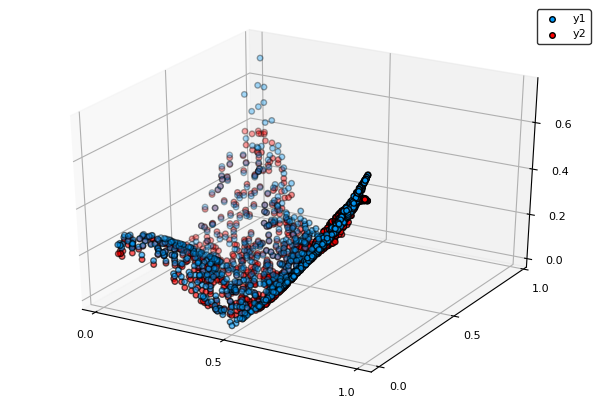

In [73]:
scatter(Xtest[1, :], Xtest[2, :], f(Xtest))
scatter!(Xtest[1, :], Xtest[2, :], fhat(Xtest), color="red")

In [211]:
n = 10
y = rand(n)
X = hcat(5 + rand(n)*10, Y[1 + Int.(y .> 1/3) + Int.(y .> 2/3)]);

In [212]:
V = u_crra((1+r)*X[:,1] + X[:,2], γ);

In [213]:
mZero = MeanZero()                   #Zero mean function
kern = SE(0.0,0.0) + SE(0.0,0.0)
@time gp = GP(X',V,mZero,kern)
@time optimize!(gp) 

  0.000131 seconds (102 allocations: 8.313 KiB)
  0.009309 seconds (19.32 k allocations: 1.121 MiB)


Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-2.0,0.0,0.0,0.0,0.0]
 * Minimizer: [-24.6011923129197,2.483286551555412, ...]
 * Minimum: -3.531002e+01
 * Iterations: 27
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: true
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 109
 * Gradient Calls: 109


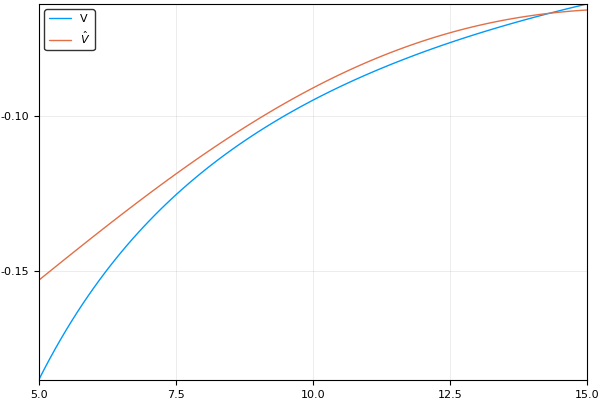

In [214]:
plot(linspace(5, 15, 100), u_crra((1+r)*linspace(5, 15, 100) + 0.25, γ), label = "V")
plot!(linspace(5, 15, 100), predict_y(gp, hcat(linspace(5, 15, 100), fill(0.25, 100))'), label = L"\hat{V}")


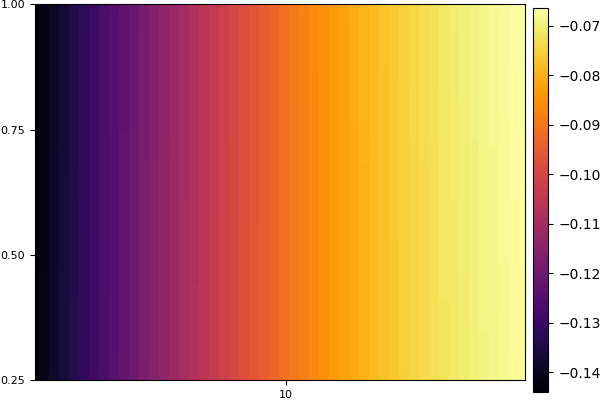

In [215]:
heatmap(gp)

In [218]:
t = zeros(n)
cons = zeros(n)
iteration = 0
stop = false

@time while !stop
    X = (5 + rand(n)*10, 1 + Int.(y .> 1/3) + Int.(y .> 2/3))
    
    for i in 1:length(X[1])
        value(c) = - (u_crra(c,γ) + β * Π[X[2][i], :]' * predict_y(gp, [fill((1 + r) * X[1][i] + Y[X[2][i]] - c, length(Y)) Y]')[1])
        res = optimize(value, 0, (1 + r) * X[1][i] + Y[X[2][i]], GoldenSection())
        t[i] = - res.minimum
        cons[i] = res.minimizer
    end
    
    gp = GP(hcat(X[1], Y[X[2]])', t, mZero, kern)
    optimize!(gp)
    
    iteration += 1
    if iteration == 200
        stop = true
    end
end

Base.LinAlg.PosDefException(3)
171.455747 seconds (93.68 M allocations: 4.438 GiB, 0.89% gc time)



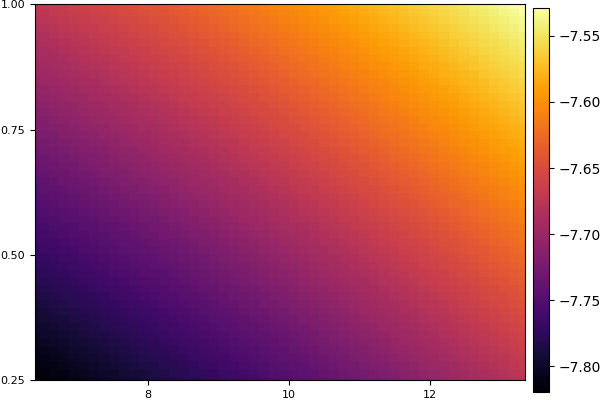

In [219]:
heatmap(gp)